In [382]:
import numpy as np
import matplotlib.pyplot as plt
from ssm_kalman import run_ssm_kalman


In [383]:
X = np.loadtxt('ssm_spins.txt')

theta1 = 2 * np.pi / 180
theta2 = 2 * np.pi / 90

A = 0.99*np.array([
    [np.cos(theta1), -np.sin(theta1), 0, 0],
    [np.sin(theta1),  np.cos(theta1), 0, 0],
    [0,               0,              np.cos(theta2), -np.sin(theta2)],
    [0,               0,              np.sin(theta2),  np.cos(theta2)]
])

Q = np.eye(4) - A @ A.T

C = np.array([
    [1,   0,   1,   0],
    [0,   1,   0,   1],
    [1,   0,   0,   1],
    [0,   0,   1,   1],
    [0.5, 0.5, 0.5, 0.5]
])

R = np.eye(C.shape[0])

Y0 = np.zeros(4)
Q0 = np.eye(4)

print("A:\n", A, "\n")
print("Q:\n", Q, "\n")
print("C:\n", C, "\n")
print("R:\n", R)
print("Y0:\n", Y0)
print("Q0:\n", Q0)

A:
 [[ 0.98939692 -0.0345505   0.          0.        ]
 [ 0.0345505   0.98939692  0.          0.        ]
 [ 0.          0.          0.98758841 -0.06905891]
 [ 0.          0.          0.06905891  0.98758841]] 

Q:
 [[0.0199 0.     0.     0.    ]
 [0.     0.0199 0.     0.    ]
 [0.     0.     0.0199 0.    ]
 [0.     0.     0.     0.0199]] 

C:
 [[1.  0.  1.  0. ]
 [0.  1.  0.  1. ]
 [1.  0.  0.  1. ]
 [0.  0.  1.  1. ]
 [0.5 0.5 0.5 0.5]] 

R:
 [[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
Y0:
 [0. 0. 0. 0.]
Q0:
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [384]:
def logdet(A):
    L = np.linalg.cholesky(A)
    return 2 * np.sum(np.log(np.diag(L)))

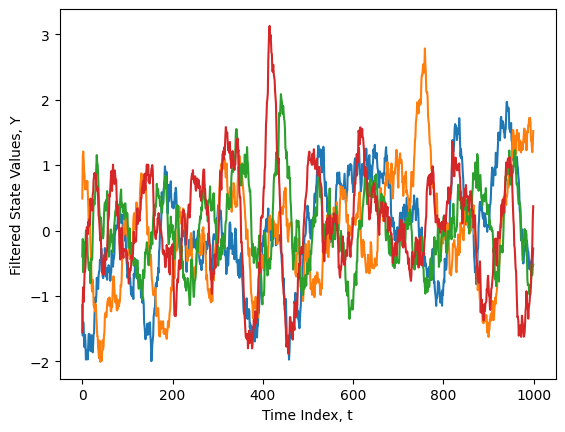

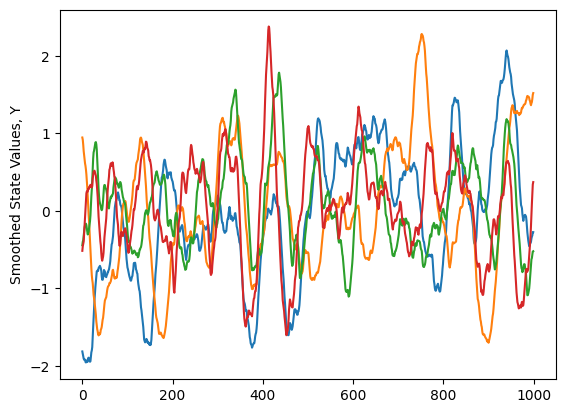

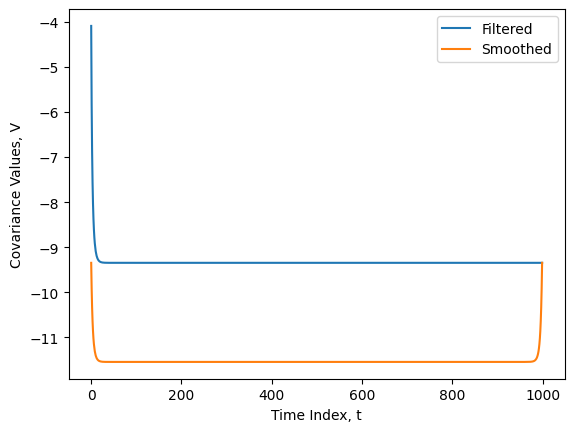

In [385]:
Y_filt,V_filt,_,L_filt = run_ssm_kalman(X.T,Y0,Q0,A,Q,C,R,'filt')
Y_smooth,V_smooth,Vj_smooth,L_smooth = run_ssm_kalman(X.T,Y0,Q0,A,Q,C,R,'smooth')

plt.figure()
plt.plot(Y_filt.T)
plt.xlabel('Time Index, t')
plt.ylabel('Filtered State Values, Y')
plt.show()

plt.figure()
plt.plot(Y_smooth.T)
plt.ylabel('Smoothed State Values, Y')
plt.show()

plt.figure(2)
plt.plot([logdet(V_t) for V_t in V_filt], label = 'Filtered')
plt.plot([logdet(V_t) for V_t in V_smooth], label = 'Smoothed')
plt.xlabel('Time Index, t')
plt.ylabel('Covariance Values, V')
plt.legend()
plt.show()



In [386]:
Y_filt.shape

(4, 1000)

In [387]:
def compute_expectations(Y_t, V_t, Vj_t):
    """
    Y_t
    V_t
    Vj_t
    """
    E_y = Y_t.T
    E_yyT = V_t + np.einsum('it,jt->tij', Y_t,Y_t)
    E_yyprevT = Vj_t[1:, :, :] + np.einsum('it,jt->tij', Y_t[:, :-1],Y_t[:,1:])
    return E_y, E_yyT, E_yyprevT


def update_C(X_t, E_y, E_yyT):
    """
    X_t
    E_y
    E_yyT
    C_new
    """
    C_new = (X_t.T @ E_y) @ np.linalg.inv(np.sum(E_yyT, axis = 0))
    return C_new

def update_R(X_t, E_y, C_new, T):
    """
    X_t
    E_y
    C_new
    T
    R_new
    """
    R_new = ((X_t.T@X_t) - ((X_t.T@E_y)@C_new.T))/T
    return R_new

def update_A(E_yyprevT, E_yyT):
    """
    E_yyprevT
    E_yyT
    A_new
    """
    A_new = np.sum(E_yyprevT, axis = 0) @ np.linalg.inv(np.sum(E_yyT, axis = 0))
    return A_new

def update_Q(E_yyT, E_yyprevT, A_new, T):
    """
    E_yyT
    E_yyprevT
    A_new
    T
    Q_new
    """
    Q_new = (np.sum(E_yyT, axis = 0) - (np.sum(E_yyprevT, axis = 0)@A_new.T))/(T-1)
    return Q_new


def e_step(X_t, Y_t, Q_t, A, Q, C, R):
    """
    SHOULD RUN_SSM_KALMAN BE HERE???
    """
    Y_t,V_t,Vj_t,L_t = run_ssm_kalman(X_t.T,Y_t,Q_t,A,Q,C,R,'smooth')
    E_y, E_yyT, E_yyprevT = compute_expectations(Y_t, V_t, Vj_t)
    return E_y, E_yyT, E_yyprevT, Y_t.T, V_t, Vj_t, L_t


def m_step(X_t, E_y, E_yyT, E_yyprevT):
    """
    """
    T = len(X_t)
    C_new = update_C(X_t, E_y, E_yyT)
    R_new = update_R(X_t, E_y, C_new, T)
    A_new = update_A(E_yyprevT, E_yyT)
    Q_new = update_Q(E_yyT, E_yyprevT, A_new, T)
    return A_new, Q_new, C_new, R_new


def batch_em_run(X_t, init_vals, max_iter=50, tol=1e-100):
    """
    """
    l_history = []
    delta = np.inf
    total_l_prev = -np.inf
    i = 0
    Y_t = np.reshape(init_vals['Y0'], (1, 4))
    V_t = np.reshape(init_vals['Q0'], (1, 4, 4))
    A = init_vals['A']
    Q = init_vals['Q']
    C = init_vals['C']
    R = init_vals['R']
    while i<max_iter and delta>tol:
        E_y, E_yyT, E_yyprevT, Y_t, V_t, Vj_t, L_t = e_step(X_t, Y_t[0,:], V_t[0,:,:], A, Q, C, R)
        A, Q, C, R = m_step(X_t, E_y, E_yyT, E_yyprevT)
        total_l = np.sum(L_t, axis = 0)
        delta = total_l - total_l_prev
        l_history += [total_l]
        total_l_prev = total_l
        i += 1
    return A, Q, C, R, l_history

def initialise_params(setting='real'):
    if setting == 'real':

        A = 0.99*np.array([
            [np.cos(theta1), -np.sin(theta1), 0, 0],
            [np.sin(theta1),  np.cos(theta1), 0, 0],
            [0,               0,              np.cos(theta2), -np.sin(theta2)],
            [0,               0,              np.sin(theta2),  np.cos(theta2)]
        ])

        Q = np.eye(4) - A @ A.T

        C = np.array([
            [1,   0,   1,   0],
            [0,   1,   0,   1],
            [1,   0,   0,   1],
            [0,   0,   1,   1],
            [0.5, 0.5, 0.5, 0.5]
        ])

        R = np.eye(C.shape[0])

    elif setting == 'random':

        A = np.random.rand(4, 4)
        C = np.random.rand(5, 4)

        # Q = np.random.rand(4, 4)
        # Q = Q@Q.T
        # R = np.random.rand(5, 5)
        # R = R@R.T

        Q = np.eye(4)
        R = np.eye(5)

    else:
        raise Warning("Set valid initialise_params setting!")
    return A, Q, C, R

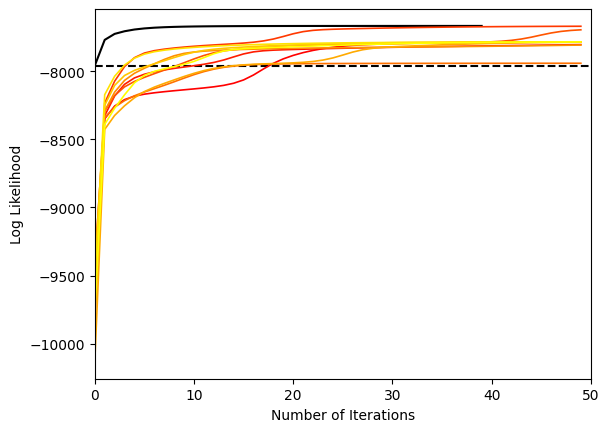

In [388]:
n_repeats = 10

plt.figure()



X = np.loadtxt('ssm_spins.txt')
Y0 = np.zeros(4)
Q0 = np.eye(4)
A, Q, C, R = initialise_params('real')
init_vals = {'Y0':Y0,
             'Q0':Q0,
             'A':A,
             'Q':Q,
             'C':C,
             'R':R,
             }

Y_smooth,V_smooth,Vj_smooth,L_smooth = run_ssm_kalman(X.T,Y0,Q0,A,Q,C,R,'smooth')
plt.axhline(np.sum(L_smooth, axis = 0), c='k', linestyle='--')
A_ssid = A
Q_ssid = Q
C_ssid = C
R_ssid = R

A, Q, C, R, l_history = batch_em_run(X, init_vals)
plt.plot(l_history, c='k')
A_real = A
Q_real = Q
C_real = C
R_real = R

A_rand = []
Q_rand = []
C_rand = []
R_rand = []
for seed in range(n_repeats):
    X = np.loadtxt('ssm_spins.txt')
    Y0 = np.zeros(4)
    Q0 = np.eye(4)
    A, Q, C, R = initialise_params('random')
    init_vals = {'Y0':Y0,
                'Q0':Q0,
                'A':A,
                'Q':Q,
                'C':C,
                'R':R,
                }

    A, Q, C, R, l_history = batch_em_run(X, init_vals)
    color = plt.cm.autumn(seed / (n_repeats - 1))
    plt.plot(l_history, c=color, linewidth=1.2)
    A_rand += [A]
    Q_rand += [Q]
    C_rand += [C]
    R_rand += [R]
plt.ylabel('Log Likelihood')
plt.xlabel('Number of Iterations')
plt.xlim(0, 50)
plt.show()

In [395]:
print("A_ssid:\n", A_ssid, "\n")
print("Q_ssid:\n", Q_ssid, "\n")
print("C_ssid:\n", C_ssid, "\n")
print("R_ssid:\n", R_ssid, "\n")

print("A_real:\n", A_real, "\n")
print("Q_real:\n", Q_real, "\n")
print("C_real:\n", C_real, "\n")
print("R_real:\n", R_real, "\n")

for seed in range(n_repeats):
    print("A_rand_" + str(seed) + ":\n", A_rand[seed], "\n")
    print("Q_rand_" + str(seed) + ":\n", Q_rand[seed], "\n")
    print("C_rand_" + str(seed) + ":\n", C_rand[seed], "\n")
    print("R_rand_" + str(seed) + ":\n", R_rand[seed], "\n")

A_ssid:
 [[ 0.98939692 -0.0345505   0.          0.        ]
 [ 0.0345505   0.98939692  0.          0.        ]
 [ 0.          0.          0.98758841 -0.06905891]
 [ 0.          0.          0.06905891  0.98758841]] 

Q_ssid:
 [[0.0199 0.     0.     0.    ]
 [0.     0.0199 0.     0.    ]
 [0.     0.     0.0199 0.    ]
 [0.     0.     0.     0.0199]] 

C_ssid:
 [[1.  0.  1.  0. ]
 [0.  1.  0.  1. ]
 [1.  0.  0.  1. ]
 [0.  0.  1.  1. ]
 [0.5 0.5 0.5 0.5]] 

R_ssid:
 [[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]] 

A_real:
 [[ 1.00514656  0.05330756  0.19278622 -0.2196716 ]
 [-0.00935522  0.94717046  0.08069304  0.04954302]
 [ 0.00177966 -0.00281929  0.94153893 -0.02094041]
 [ 0.01637461  0.0107664   0.103345    0.88407758]] 

Q_real:
 [[ 0.11355274 -0.03582818 -0.0002229   0.02010165]
 [-0.03582818  0.0880172  -0.00513854  0.00354639]
 [-0.0002229  -0.00513854  0.00627928  0.00115842]
 [ 0.02010165  0.00354639  0.00115842  0.01133984]] 

C_real: